# PLN Assignment 1

In the scope of the DARGMINTS project, an annotation project was carried out which consisted of annotating argumentation structures in opinion articles published in the Público newspaper. The annotation included several layers:

Selecting text spans that are taken to have an argumentative role (either as premises or conclusions of arguments) -- these are Argumentative Discourse Units (ADU).
Connecting such ADUs through support or attack relations.
Classifying the propositional content of ADUs as propositions of fact, propositions of value, or propositions of policy; within propositions of value, distinguish between those with a positive (+) or negative (-) connotation.
In a proposition of fact, the content corresponds to a piece of information that can be checked for truthness. This does not usually happen with propositions of value, which denote value judgments with a strong subjective nature; often, they also have a (positive or negative) polarity attached. A proposition of policy prescribes or suggests a certain line of action, often mentioning the agents or entities that are capable of carrying out such policies.

The aim of this assignment is to build a classifier of types of ADUs, thus focusing on the last annotation step described above. For that, you have access to two different files:

A file containing the content of each annotated ADU span and its 5-class classification: Value, Value(+), Value(-), Fact, or Policy. For each ADU, we also know the annotator and the document from which it has been taken.
A file containing details for each opinion article that has been annotated, including the full article content.
Besides ADU contents, you can make use of any contextual information provided in the corresponding opinion article.

Each opinion article has been annotated by 3 different annotators. For that reason, you will find in the ADU file an indication of which annotator has obtained the ADU. It may happen that the same ADU has been annotated by more than one annotator. When that is the case, they do not necessarily agree on the type of proposition.

How good a classifier (or set of classifiers) can you get? Don't forget to properly split the dataset in a sensible manner, so that you have a proper test set. Start by obtaining an arbitrary baseline, against which you can then compare your improvements.

## Importing the data

In order to fulfill this NLP task we will use `pandas`, `sklearn`, `nltk`, `numpy`, `matplotlib`, `seaborn` and other Python libraries


In [2]:
%cd FEUP-PLN

/content/FEUP-PLN


In [2]:
import pandas as pd
import numpy as np

ADUs = pd.read_excel("data/OpArticles_ADUs.xlsx")
articles = pd.read_excel("data/OpArticles.xlsx")

ADUs.isnull().values.any() #check NaNs


False

In [19]:
ADUs["label"].value_counts()

Value       8102
Fact        3663
Value(-)    2900
Value(+)    1411
Policy       667
Name: label, dtype: int64

## Handling repeated text spans

Some text spans were annotated by more than one annotator. Therefore, it may be the case that some text spans have different labels, which may harm the training phase.

In [3]:
unique_spans = np.unique(ADUs[['article_id', 'ranges']].values)
(unique_spans.shape, ADUs["tokens"].shape)

((12302,), (16743,))

As we can see, more than 4000 text spans were evaluated by more than one annotator. Now let's check how many of these text spans receive different labels

## Data preparation

The next step is to cleanup the dataset, applying text normalization techniques:
 - Removing non-alphabetic chars
 - Lowercasing
 - Removing stop words
 - Stemming/lemmatization
 
However, before applying these techniques, let's try to remove the repeated annotations that may confuse the classifiers on the future steps. In order to decide which is the correct label for each (article_id, range) pair, we compute the majority.

In [4]:
grouped_df = ADUs.groupby(by=['article_id', 'ranges'])
dataset_dict = {"tokens": [], "label": []}

for i, group in grouped_df:
    dict_counts = {x: group["label"].value_counts()[x] for x in np.unique(group[['label']].values)}
    final_label = max(dict_counts.items(), key=lambda x: x[1])
    dataset_dict["tokens"].append(group["tokens"].values[0])
    dataset_dict["label"].append(final_label[0])
    
dataset = pd.DataFrame(dataset_dict, columns = ["tokens", "label"])



In [5]:
print(ADUs["label"].value_counts())
dataset["label"].value_counts()

Value       8102
Fact        3663
Value(-)    2900
Value(+)    1411
Policy       667
Name: label, dtype: int64


Value       5003
Fact        2897
Value(-)    2401
Value(+)    1181
Policy       539
Name: label, dtype: int64

We managed to reduce the amount of rows in the dataframe -> some of them had repeated/conflictuous labels. 

In [ ]:
!python -m spacy download pt_core_news_sm

In [ ]:
import spacy
from spacy.lang.pt.examples import sentences 
import pt_core_news_sm

nlp = pt_core_news_sm.load()
test_sentence = "Os combustíveis atingiram picos históricos na passada sexta-feira."
for token in nlp(test_sentence):
    print(token.text, token.pos_, token.dep_, token.lemma_)

  SPACE   
atingiram VERB ROOT atingir
picos NOUN obj pico
históricos ADJ amod histórico
na PROPN ROOT o
passada VERB acl passar
sexta-feira NOUN nmod sexta-feira
. PUNCT punct .


## POS-tagging

Apply POS-tagging (with a pre-trained model), to the full sentence of the corresponding text span.

In [25]:
#Add a new column with POS-tags that will be gathered next
POS_list = []
#ADUs["POS"] = []

for row in ADUs.iterrows():
    POS_list.append((row[1]["article_id"] + row[1]["ranges"]))

ADUs["POS"] = POS_list

In [27]:
import nltk
nltk.download('punkt')

for i, group in grouped_df:
    article = articles.loc[articles["article_id"] == i[0]]

    range = group["ranges"].unique()[0]
    start = eval(range)[0][0]
    end = eval(range)[0][1] 
    body = article["body"].values[0]

    body_sentences = nltk.tokenize.sent_tokenize(body)
    current_pos, current_sent = 0,0
    while current_pos < start:
        if current_sent == len(body_sentences): break
        current_pos += len(body_sentences[current_sent])
        current_sent += 1

    tags = [token.pos_ for token in nlp(body_sentences[current_sent - 1])]

    ADUs["POS"].replace(i[0] + i[1], " ".join(tags), inplace=True)

  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [28]:
ADUs["POS"].describe()

count                                    16743
unique                                    5836
top       DET NOUN VERB ADP DET ADJ NOUN PROPN
freq                                        57
Name: POS, dtype: object

## Extract features

Let's start by adding the count of each POS-tag for each document

In [29]:
unique_tags_l = []

for tags in ADUs["POS"].values:
    tags_list = tags.split(" ")
    unique_tags_l += tags_list

unique_tags = set(unique_tags_l)
unique_tags


{'ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SPACE',
 'SYM',
 'VERB',
 'X'}

In [30]:
tag_counts_dict = {}

for tag in list(unique_tags):
    name = tag + "_count"
    tag_counts_dict[name] = []
    for row in ADUs.iterrows():
    tags_list = row[1]["POS"].split(" ")
    tag_counts_dict[name].append(tags_list.count(tag) / len(tags_list))
    

for k in tag_counts_dict.keys():
    ADUs[k] = tag_counts_dict[k]


## Extract topics as features

In [31]:
topics_l = []
for row in ADUs.iterrows():
    ID = row[1]["article_id"]
    article = articles.loc[articles["article_id"] == ID]
    topic = article["topics"].values[0]
    topics_l.append(topic)

ADUs["topics"] = topics_l

## Saving tagged data

In [32]:
ADUs.to_excel("data/ADUs_pre-processed.xlsx")

## Reading the pre-processed dataset

In [2]:
%cd FEUP-PLN

/content/FEUP-PLN


In [18]:
import pandas as pd
import numpy as np
import nltk

ADUs = pd.read_excel("data/ADUs_pre-processed.xlsx")

grouped_df = ADUs.groupby(by=['article_id', 'ranges'])
dataset_dict = {"tokens": [], "label": []}

for c in ADUs.columns[8:]:
    dataset_dict[c] = []

for i, group in grouped_df:
    dict_counts = {x: group["label"].value_counts()[x] for x in np.unique(group[['label']].values)}
    final_label = max(dict_counts.items(), key=lambda x: x[1])
    dataset_dict["tokens"].append(group["tokens"].values[0])
    dataset_dict["label"].append(final_label[0])

    for c in ADUs.columns[8:]:
        dataset_dict[c].append(group[c].values[0])
    
    
    
dataset = pd.DataFrame(dataset_dict, columns = dataset_dict.keys())
#dataset = ADUs

## Analyzing Stopwords
Some stopwords from `nltk` should not be ignored by the model, as they have correlation with the label.

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords_list = stopwords.words("portuguese")


stopwords_list.remove("não")
stopwords_list.remove("muito")
stopwords_list.remove("mais")

In [ ]:
dataset = ADUs

In [ ]:
!python -m spacy download pt_core_news_sm

In [ ]:
import pt_core_news_sm
import re
nltk.download('rslp')
from nltk.stem import RSLPStemmer # portuguese stemmer
nlp = pt_core_news_sm.load()
corpus = []
#stemmer = RSLPStemmer()
for row in dataset.iterrows():
    # get review and remove non alpha chars
    review = re.sub('[^a-zA-Z!?]', ' ',row[1]["tokens"])
    # to lower-case
    review = review.lower()
    # split into tokens, apply stemming and remove stop words
    review = ' '.join([word.lemma_.lower().strip() + word.pos_ for word in nlp(review) if not word.text in stopwords_list])
    corpus.append(review)


dataset["corpus"] = corpus


## Generating a data set

We need to transform the corpus into a collection that can be handled by a machine learning model. We will be using `sklearn`'s TfidfVectorizer class

In [34]:
column_trans = ColumnTransformer([
    ("topics", OneHotEncoder(), ["topics"]),
    ("corpus", TfidfVectorizer(ngram_range=(1,2), min_df = 2), "corpus")
    #("counts", "passthrough", ADUs.columns[8:-2])
], verbose_feature_names_out=False)

#vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df = 3)
X = column_trans.fit_transform(dataset).toarray()


In [35]:
y = dataset["label"]
print(y.shape)
print(y.head())

(16743,)
0    Value
1    Value
2    Value
3    Value
4    Value
Name: label, dtype: object


## Splitting the dataset into training and testing

The next step is to split the dataset into training and testing. We will be using a 80%-20% split. Since classes are unbalanced (*Value* examples are significantly more abundant than *Policy* examples), we need to stratify both sets -> try to get a similar class distribution for each set.

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(13394, 47744) (13394,)
(3349, 47744) (3349,)

Label distribution in the training set:
Value       6470
Fact        2961
Value(-)    2290
Value(+)    1135
Policy       538
Name: label, dtype: int64

Label distribution in the test set:
Value       1632
Fact         702
Value(-)     610
Value(+)     276
Policy       129
Name: label, dtype: int64


## Computing class weights

Since the dataset is unbalanced, we need to compute weights or apply oversampling/undersampling techniques. Otherwise predictions would be heavily biased towards the majority class.

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y.unique()),
                                        y = y                                                    
                                    )
class_weights = dict(zip(np.unique(y.unique()), class_weights))
class_weights

{'Fact': 0.8011329556814395,
 'Policy': 4.704892367906067,
 'Value': 0.4182672233820459,
 'Value(+)': 2.704386951631046,
 'Value(-)': 1.284294871794872}

## Training the models


In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cross_validation = StratifiedKFold(n_splits=5, shuffle=True)

## Resampling

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)
sm = SMOTE()

X_train, y_train = ros.fit_resample(X_train, y_train)
#y_train.value_counts()

Value       4590
Fact        4590
Value(-)    4590
Policy      4590
Value(+)    4590
Name: label, dtype: int64

### Naive Bayes
To start off, we will train a single (`Naive Bayes`) classifier that evaluates the likelihood of a document being of one of the 5 classes. This will set the baseline for which the improvements will be measured.


In [ ]:
pd.DataFrame(y_train).value_counts()

label   
Fact        4604
Policy      4604
Value       4604
Value(+)    4604
Value(-)    4604
dtype: int64

In [11]:
clf = ComplementNB()
clf.fit(X_train, y_train)
#scores = cross_validate(clf, X_train, y_train, cv = cross_validation, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
y_pred = clf.predict(X_test)
#scores

In [ ]:

#clf.fit(X_train, y_train)
scores = cross_validate(ComplementNB(), X_train, y_train, cv = cross_validation, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

scores
#y_pred = clf.predict(X_test)

{'fit_time': array([2.15442896, 2.78314996, 2.47794294, 2.14818072, 1.97649717]),
 'score_time': array([0.44557261, 0.37167501, 0.44988012, 0.38903785, 0.39175057]),
 'test_accuracy': array([0.71676803, 0.71220678, 0.7228497 , 0.7139444 , 0.714596  ]),
 'test_f1_weighted': array([0.68596699, 0.68017123, 0.69272105, 0.68337686, 0.68610397]),
 'test_precision_weighted': array([0.70895144, 0.70871513, 0.72131025, 0.70387401, 0.70800699]),
 'test_recall_weighted': array([0.71676803, 0.71220678, 0.7228497 , 0.7139444 , 0.714596  ])}

Accuracy score:  0.5404598387578382
Balanced accuracy score:  0.3538197258414087


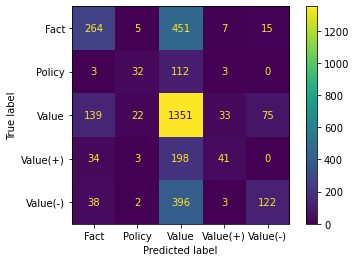

              precision    recall  f1-score   support

        Fact       0.55      0.36      0.43       742
      Policy       0.50      0.21      0.30       150
       Value       0.54      0.83      0.65      1620
    Value(+)       0.47      0.15      0.23       276
    Value(-)       0.58      0.22      0.32       561

    accuracy                           0.54      3349
   macro avg       0.53      0.35      0.39      3349
weighted avg       0.54      0.54      0.50      3349



In [12]:

def print_metrics(y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    print("Accuracy score: ", accuracy_score(y_test, y_pred))
    print("Balanced accuracy score: ", balanced_accuracy_score(y_test, y_pred))
    metrics_df = pd.DataFrame({"Precision": precision_score(y_test, y_pred, labels = classes, average = None).tolist(),
                              "Recall": recall_score(y_test, y_pred, labels = classes, average = None).tolist(),
                              "F1": f1_score(y_test, y_pred, labels = classes, average = None).tolist()},
                             index = classes)
    
    plt.show()
    return metrics_df.head()
    
print_metrics(y_test, y_pred, clf.classes_)
print(classification_report(y_test, y_pred))

Since some classifiers like SVM and Logistic Regression cannot handle multi-class classification, let's use the One vs Rest classifier. This way, we can transform this problem into a binary classification problem -> one classifier for each class.

In [ ]:
model_to_set = RandomForestClassifier(n_jobs=-1)

cross_validation = StratifiedKFold(n_splits=5)
parameters = {
    "max_depth": [int(x) for x in np.linspace(10, 110, num=5)],
    "min_samples_leaf": [int(x) for x in np.linspace(50, 2000, num=5)],
    "criterion": ["gini", "entropy"]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters,
                             scoring="accuracy", cv=cross_validation, n_jobs=-1, verbose=1)

model_tunning.fit(X_train, y_train)
model_tunning.best_score_
print_metrics(y_test, model_tunning.predict(X_test), clf.classes_)


## Scaling the data

Some linear models (like SVM or SGD classifiers) use euclidean distances and benefit from the normalization of the data.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## SGD Classifier

Let's now apply the Stochastic Gradient Descent optimization with a linear SVM model (`loss='hinge'`) and a Logistic Regression model (`loss=log`). Moreover, we can tune some hyperparameters to get the best possible model.
SGD implementation from sklearn optimizes the loss function to converge faster, as they use stochastic gradient descent instead of gradient descent.

In [ ]:
"""
l1-regularization -> 'built-in' feature selection (fewer features)
l2-regularization -> Prefers weight vectors with many small weights
"""

max_iterations = 10**6/np.ceil(X_train.shape[0] / 10) #Empirically,the model converges after 10^6/n where n 
                                        # the size of the test set

sgd_model = SGDClassifier(penalty="l2", 
                          average=True, class_weight=class_weights)
sgd_gs = GridSearchCV(sgd_model, n_jobs=-1, param_grid={
    "alpha": 10.0**-np.arange(1,5),
    "loss": ['log', 'modified_huber']
}, cv=cross_validation, scoring="accuracy", verbose = 1)

sgd_gs.fit(X_train, y_train)
#sgd_gs.best_score_
print(sgd_gs.best_params_)
print_metrics(y_test, sgd_gs.predict(X_test), sgd_gs.classes_)

Accuracy score:  0.47442827442827445
Balanced accuracy score:  0.3261219562197266


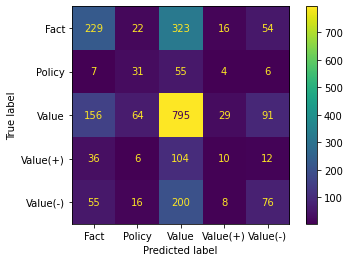

,Precision,Recall,F1
Fact,0.474120,0.355590,0.406389
Policy,0.223022,0.300971,0.256198
Value,0.538253,0.700441,0.608729
Value(+),0.149254,0.059524,0.085106
Value(-),0.317992,0.214085,0.255892


In [ ]:
print_metrics(y_test, sgd_gs.predict(X_test), sgd_gs.classes_)

Accuracy score:  0.5061212302179755
Balanced accuracy score:  0.24149950685632454


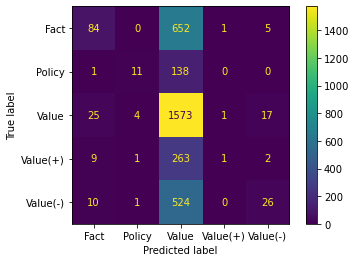

,Precision,Recall,F1
Fact,0.651163,0.113208,0.192882
Policy,0.647059,0.073333,0.131737
Value,0.499365,0.970988,0.659539
Value(+),0.333333,0.003623,0.007168
Value(-),0.520000,0.046346,0.085106


In [14]:
sgd_classifier = SGDClassifier(n_jobs=-1, shuffle=True)

sgd_classifier.fit(X_train, y_train)
print_metrics(y_test, sgd_classifier.predict(X_test), sgd_classifier.classes_)

In [ ]:
# Linear SVM model -> loss = 'hinge'

sgd_classifier = SGDClassifier(n_jobs=-1, penalty="l2", verbose = 1, shuffle=True, 
                               loss="hinge", max_iter=max_iterations)

sgd_classifier.fit(X_train, y_train)
print_metrics(y_test, sgd_classifier.predict(X_test), sgd_classifier.classes_)

## Linear SVM Classifier
To establish a comparison in terms of performance, we will use the Linear SVM classifier.


In [ ]:

svm_model = LinearSVC(class_weight="balanced", verbose=1)

svm_gs = HalvingGridSearchCV(svm_model, n_jobs=-1, param_grid = {
    "C": np.logspace(-4,4,5),
    "loss": ["hinge", "squared_hinge"]
}, cv=5, scoring="f1_weighted", verbose=3)

svm_gs.fit(X_train, y_train)
print_metrics(y_test, svm_gs.predict(X_test), svm_gs.classes_)

## Logistic Regression Classifier
We can now do the same apply the Logistic Regression classifier and compare it with the previously obtained models with SGD optimization.


Accuracy score:  0.5097043893699612
Balanced accuracy score:  0.23386642031185131


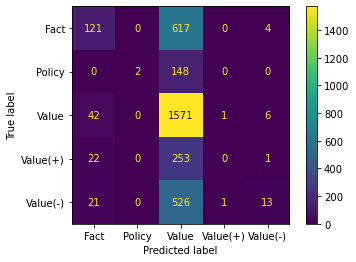

,Precision,Recall,F1
Fact,0.587379,0.163073,0.255274
Policy,1.000000,0.013333,0.026316
Value,0.504334,0.969753,0.663569
Value(+),0.000000,0.000000,0.000000
Value(-),0.541667,0.023173,0.044444


In [16]:
#Logistic Regression without hyperparameter tuning

lr_model = LogisticRegression(n_jobs=-1, verbose=1)
lr_model.fit(X_train, y_train)
print_metrics(y_test, lr_model.predict(X_test), lr_model.classes_)


In [ ]:
# Logistic Regression model
lr_model = LogisticRegression(n_jobs=-1, verbose=1)

lr_gs = GridSearchCV(lr_model, n_jobs=-1, param_grid={
    "max_iter": [100, 200, 500, 1000],
    "solver": ["sag", 'saga', 'lbfgs', "newton-cg"],
    "C": np.logspace(-4, 4, 20)
}, cv=cross_validation, scoring="accuracy", verbose = True)

lr_gs.fit(X_train, y_train)
print_metrics(y_test, lr_gs.predict(X_test), lr_gs.classes_)

In [ ]:
X_annotated = pd.concat([ADUs['annotator'], pd.DataFrame(X)], axis=1)

In [ ]:
df_A = X_annotated.loc[ADUs["annotator"] == "A"]
df_A.drop(columns = ["annotator"], inplace=True)
y_A = ADUs.loc[ADUs["annotator"] == "A"]["label"]

df_B = X_annotated.loc[ADUs["annotator"] == "B"]
df_B.drop(columns = ["annotator"], inplace=True)
y_B = ADUs.loc[ADUs["annotator"] == "B"]["label"]

df_C = X_annotated.loc[ADUs["annotator"] == "C"]
df_C.drop(columns = ["annotator"], inplace=True)
y_C = ADUs.loc[ADUs["annotator"] == "C"]["label"]

df_D = X_annotated.loc[ADUs["annotator"] == "D"]
df_D.drop(columns = ["annotator"], inplace=True)
y_D = ADUs.loc[ADUs["annotator"] == "D"]["label"]


In [48]:
X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(df_A, y_A, test_size = 0.20)

X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(df_B, y_B, test_size = 0.20)

X_C_train, X_C_test, y_C_train, y_C_test = train_test_split(df_C, y_C, test_size = 0.20)

X_D_train, X_D_test, y_D_train, y_D_test = train_test_split(df_D, y_D, test_size = 0.20)

In [ ]:
!pip install mlxtend

We train a logistic regression model for each annotator. The predictions are achieved by voting.

In [52]:
from mlxtend.classifier import EnsembleVoteClassifier

clf_A = SGDClassifier(n_jobs=-1, loss = "log")
clf_A.fit(X_A_train, y_A_train)

clf_B = SGDClassifier(n_jobs=-1, loss = "log")
clf_B.fit(X_B_train, y_B_train)

clf_C = SGDClassifier(n_jobs=-1, loss = "log")
clf_C.fit(X_C_train, y_C_train)

clf_D = SGDClassifier(n_jobs=-1, loss = "log")
clf_D.fit(X_D_train, y_D_train)

voting_clf = EnsembleVoteClassifier([clf_A, clf_B, clf_C, clf_D], voting="soft", 
                                    fit_base_estimators=False)
voting_clf.fit(X_test, y_test)
y_pred_voting = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred_voting))

C:\Users\caion\anaconda3\lib\site-packages\mlxtend\classifier\ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


              precision    recall  f1-score   support

        Fact       0.47      0.36      0.41       702
      Policy       0.50      0.01      0.02       129
       Value       0.53      0.92      0.68      1632
    Value(+)       0.80      0.01      0.03       276
    Value(-)       1.00      0.01      0.02       610

    accuracy                           0.53      3349
   macro avg       0.66      0.26      0.23      3349
weighted avg       0.63      0.53      0.42      3349



## Error Analysis -> TODO
